### Import Libraries

In [39]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf 
import seaborn as sns
import matplotlib.pyplot as plt
import missingno
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, auc, roc_curve
import warnings
from IPython.display import display, HTML

warnings.filterwarnings("ignore")
%matplotlib inline

<!--  -->

### Sample Data

In [8]:
# Reproducibility
np.random.seed(11)

# No. of Sample Data points
num_samples = 200

# Selecting Uniform Distribution: To get a fair chance for each value within this interval, so that there won't be any bias.

# Feature: Load Capacity
load_capacity_bike = np.random.uniform(50, 100, num_samples)
load_capacity_car = np.random.uniform(150, 300, num_samples-10)

# Feature: Vechicle Weight
vehicle_weight_bike = np.random.uniform(800, 1500, num_samples)
vehicle_weight_car = np.random.uniform(4000, 6000, num_samples-10)

# Feature: Engine CC
engine_cc_bike = np.random.uniform(500, 1500, num_samples)
engine_cc_car = np.random.uniform(5000, 7000, num_samples-10)

# Labels: Bikes[0] and Cars[1]
labels_biks = np.zeros(num_samples)
labels_cars = np.ones(num_samples-10)

# Concatinate Data
all_load_capacity = np.concatenate([load_capacity_bike, load_capacity_car])
all_vehicle_weight = np.concatenate([vehicle_weight_bike, vehicle_weight_car])
all_engine_cc = np.concatenate([engine_cc_bike, engine_cc_car])
all_labels = np.concatenate([labels_biks, labels_cars]) 

# Data Frame
df_sample_data = pd.DataFrame({"load_capacity": all_load_capacity,
                                "vehicle_weight": all_vehicle_weight,
                                "engine_cc": all_engine_cc,
                                "vehicle_type": all_labels
                                })

# Some Outliers [i.e., Miss labeled Outliers, not data spread / margin level outliers]
df_outliers = pd.DataFrame({"load_capacity": [180, 200, 51, 89],
                                "vehicle_weight": [4100, 4200, 900, 750],
                                "engine_cc": [5200, 5500, 502, 652],
                                "vehicle_type": [0,0,1,1]})

# Appending Outliers to Sample Data
df_sample_data = pd.concat([df_sample_data, df_outliers], ignore_index=True)

<!--  -->

### Descriptive Info

In [9]:
print("Columns: {0}".format(df_sample_data.columns.tolist()))
print(f"Data Shape: {df_sample_data.shape}")
df_sample_data.info()

Columns: ['load_capacity', 'vehicle_weight', 'engine_cc', 'vehicle_type']
Data Shape: (394, 4)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394 entries, 0 to 393
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   load_capacity   394 non-null    float64
 1   vehicle_weight  394 non-null    float64
 2   engine_cc       394 non-null    float64
 3   vehicle_type    394 non-null    float64
dtypes: float64(4)
memory usage: 12.4 KB


In [10]:
# Sample Bike Data Overview
display(HTML(df_sample_data[df_sample_data["vehicle_type"] == 0].head(5).to_html()))

# Sample Car Data Overview
display(HTML(df_sample_data[df_sample_data["vehicle_type"] == 1].head(5).to_html()))

,load_capacity,vehicle_weight,engine_cc,vehicle_type
0,59.013484,1289.167218,958.721724,0.0
1,50.973762,1482.636927,713.541593,0.0
2,73.160926,1497.079806,1199.045283,0.0
3,86.246696,1043.416048,1375.725819,0.0
4,71.010180,1238.034337,1259.745092,0.0


,load_capacity,vehicle_weight,engine_cc,vehicle_type
200,159.816987,5421.995258,6992.961311,1.0
201,236.198392,4824.024135,5248.541293,1.0
202,253.190437,4214.876446,6440.613568,1.0
203,235.245875,5535.102854,6055.121875,1.0
204,240.558982,4973.257101,5655.657975,1.0


<!--  -->

### Descriptive Stats

In [11]:
df_sample_data.describe()

,load_capacity,vehicle_weight,engine_cc,vehicle_type
count,394.000000,394.000000,394.000000,394.000000
mean,147.491121,3037.915686,3416.595207,0.487310
std,79.830751,1993.086418,2509.185507,0.500474
min,50.639041,750.000000,502.000000,0.000000
25%,74.974528,1120.538649,985.626579,0.000000
50%,98.427653,1489.192383,1464.325876,0.000000
75%,220.413025,5000.897758,5847.527064,1.000000
max,299.066470,5990.253331,6996.722919,1.000000


<!--  -->

### Missing Rows

In [6]:
df_sample_data.isna().sum().reset_index().rename(columns={"index":"columns", 0:"count"})

,columns,count
0,load_capacity,0
1,vehicle_weight,0
2,engine_cc,0
3,vehicle_type,0


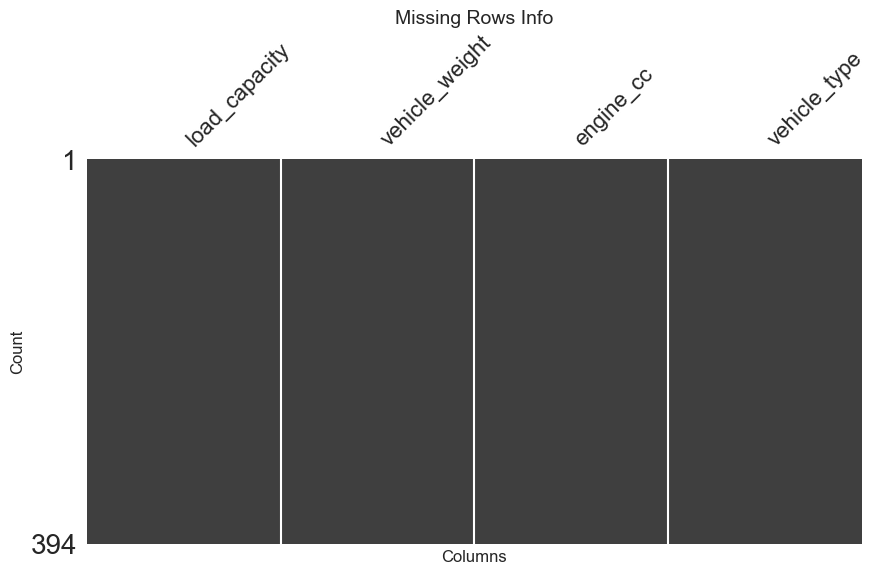

In [7]:
sns.set_style("dark")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
missingno.matrix(df_sample_data, ax=axes)
axes.set_title("Missing Rows Info", fontsize=14)
axes.set_ylabel("Count", fontsize=12)
axes.set_xlabel("Columns", fontsize=12)
plt.show()

Observation

- No missing values, hence no need to handle missing values issue

<!--  -->

### EDA

- `Features Data Spread`

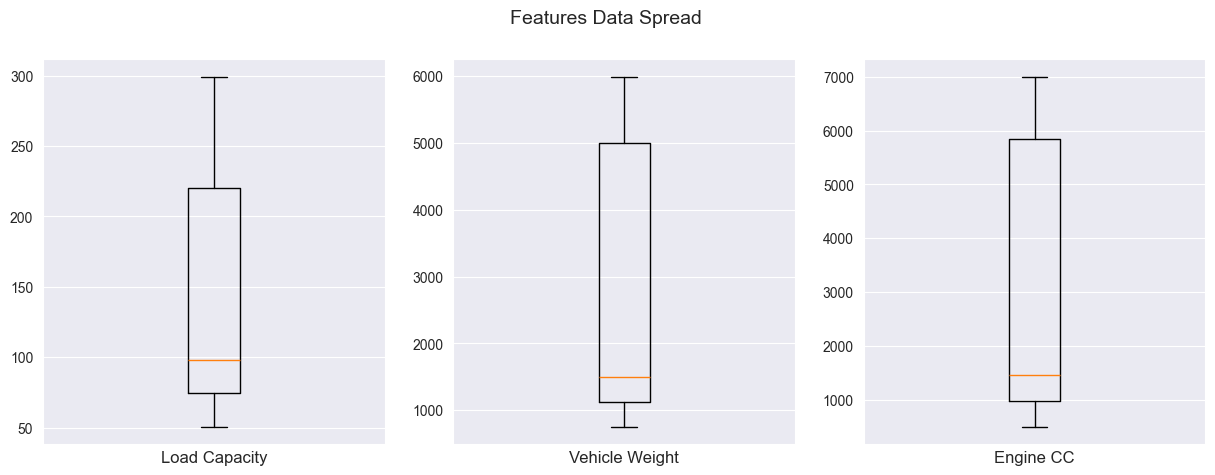

In [8]:
sns.set_style("darkgrid")
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(15, 5))

axes[0].boxplot(df_sample_data["load_capacity"])
axes[0].set_xlabel("Load Capacity", fontsize=12)
axes[0].set_xticks([])

axes[1].boxplot(df_sample_data["vehicle_weight"])
axes[1].set_xlabel("Vehicle Weight", fontsize=12)
axes[1].set_xticks([])

axes[2].boxplot(df_sample_data["engine_cc"])
axes[2].set_xlabel("Engine CC", fontsize=12)
axes[2].set_xticks([])

plt.suptitle("Features Data Spread", fontsize=14)
plt.show()

Observation

- As there are no potential outliers beyond boxplot whiskers(which is based on IQR rule) margin.
- So, handling margin related outliers steps are not necessary in this case.

- `Target Data [0: Bike, 1: Car]`

In [9]:
df_counts = df_sample_data["vehicle_type"].value_counts().reset_index()

df_counts

,vehicle_type,count
0,0.0,202
1,1.0,192


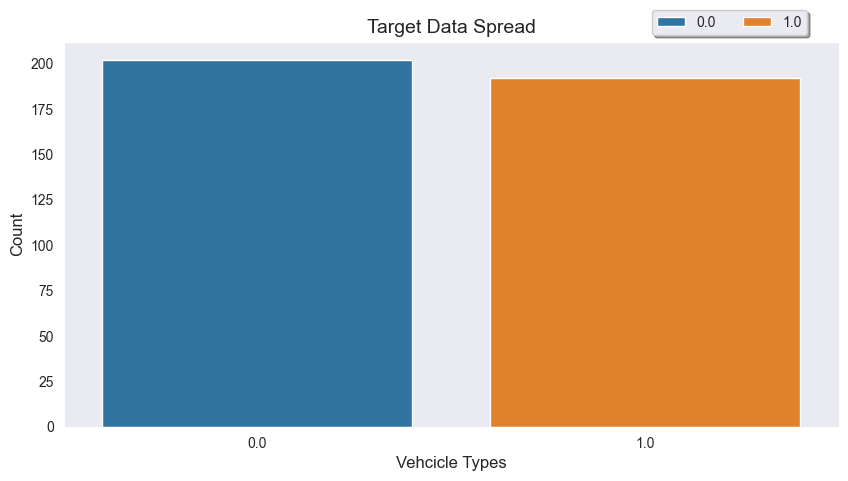

In [10]:
# Plot
sns.set_style("dark")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(10,5))
sns.barplot(x="vehicle_type", y="count", data=df_counts, hue="vehicle_type", legend=True, ax=axes)
axes.set_title("Target Data Spread", fontsize=14)
axes.set_ylabel("Count", fontsize=12)
axes.set_xlabel("Vehcicle Types", fontsize=12)
plt.legend(loc="center left", bbox_to_anchor=(.75, 1.05), fancybox=True, shadow=True, ncol=2, prop={"size":10})
plt.show()

Observation 

- Reasonably balanced dataset, hence we can have good chance of having target variable's all classes in both train and test.
- So need to handle imbalanced dataset steps here.

- `Predictors vs Target Variable Classes`

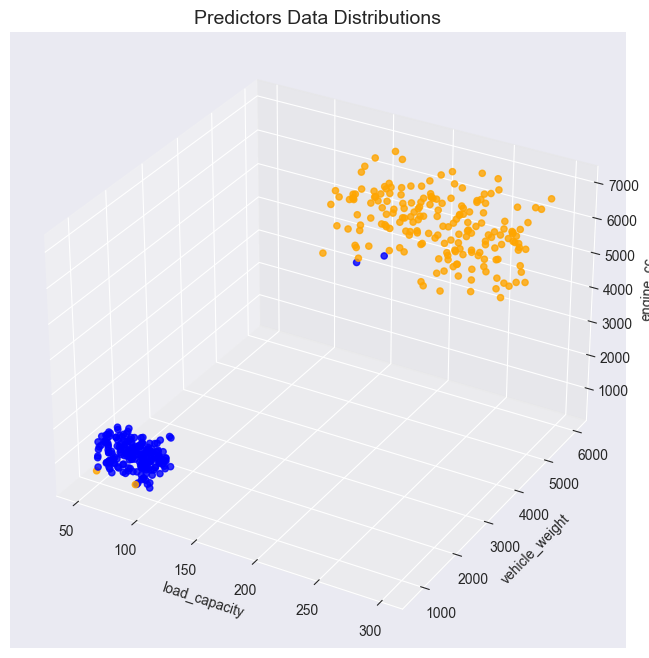

In [11]:
col_1 = "load_capacity"; col_2 = "vehicle_weight"; col_3 = "engine_cc"

sns.set_style("dark")
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
color_map = {0: 'blue', 1: 'orange'}
colors = [color_map[x] for x in df_sample_data["vehicle_type"]]
ax.scatter(df_sample_data[col_1],
            df_sample_data[col_2],
            df_sample_data[col_3],
            #c='red',
            c=colors,
            marker='o', 
            alpha=0.8)
ax.set_xlabel(col_1)
ax.set_ylabel(col_2)
ax.set_zlabel(col_3)
# plt.title("{} vs {} vs {}".format(col_1, col_2, col_3))
plt.title("Predictors Data Distributions", fontsize=14)
plt.show()

Observation
- Wantedely we induced 2 outliers in the data, which is clearly visible here. The reason for adding here, to replicate real world situation and wanted to handle this outlier case.

<!--  -->

### Features Scaling

- Logistic Regression is distance-dependent [i.e., signed distance where distance between data points & hyperplane ]. If features have vastly different scales (e.g., weight(kilos-thousands) vs. engine(cc-hundards)), it can prioritize features with larger scales even if they are less relevant for classification. Scaling features to a similar range can help mitigate this issue.
- Features should be ``normalized`` or ``standardized`` so that they contribute equally to the distance calculation. Without normalization/standardization, features with larger scales can dominate the distance metric.
- Both below scaling functions doesn't make data into normal distribution, they just brings all features under one margin. Main difference between them are. 
- ``Normalization``
    - The distribution of your features is unknown or irrelevant to your analysis. So it doesn't hold underlying distribution, meaning that it doesnt change the underlying distribution.
- ``Standardization``
    - The underlying distribution of your features is important to the model (e.g., assuming normality for certain algorithms like Linear Regression). It holds underlying distribution, meaning that it might change the underlying distribution.

In [15]:
# Initializing : Scaling[Min Max Scaling]
scaler = MinMaxScaler()

# Fit
df_sample_data_scaled = scaler.fit_transform(df_sample_data[["load_capacity", "vehicle_weight", "engine_cc"]])

# Prepare dataframe
df_sample_data_scaled = pd.DataFrame(df_sample_data_scaled, columns=["load_capacity", "vehicle_weight", "engine_cc"])
df_sample_data_scaled["vehicle_type"] = df_sample_data["vehicle_type"]

df_sample_data_scaled.head(10)

,load_capacity,vehicle_weight,engine_cc,vehicle_type
0,0.033710,0.102890,0.070322,0.0
1,0.001347,0.139809,0.032571,0.0
2,0.090658,0.142566,0.107325,0.0
3,0.143332,0.055993,0.134529,0.0
4,0.082000,0.093132,0.116671,0.0
5,0.095128,0.135425,0.038207,0.0
6,0.000000,0.092968,0.119518,0.0
7,0.095519,0.126134,0.119437,0.0
8,0.186981,0.102725,0.070569,0.0
9,0.168664,0.014471,0.115930,0.0


- As our sample data necessarily to be Normally distributed.
- As per the Logistic Regression - probabilitic interpretation. It does assume's that predictors follows normal data distribution & target column follows bernoulli distribution. So that it can handle linearity in data relation, as predictors need to be linear in nature. 

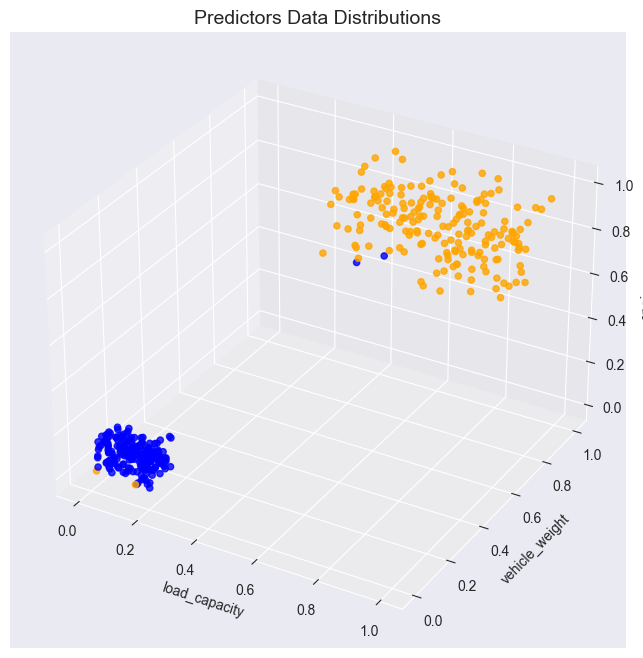

In [16]:
col_1 = "load_capacity"; col_2 = "vehicle_weight"; col_3 = "engine_cc"

sns.set_style("dark")
fig = plt.figure(figsize=(15,8))
ax = fig.add_subplot(111, projection='3d')
color_map = {0: 'blue', 1: 'orange'}
colors = [color_map[x] for x in df_sample_data_scaled["vehicle_type"]]
ax.scatter(df_sample_data_scaled[col_1],
            df_sample_data_scaled[col_2],
            df_sample_data_scaled[col_3],
            #c='red',
            c=colors,
            marker='o', 
            alpha=0.8)
ax.set_xlabel(col_1)
ax.set_ylabel(col_2)
ax.set_zlabel(col_3)
# plt.title("{} vs {} vs {}".format(col_1, col_2, col_3))
plt.title("Predictors Data Distributions", fontsize=14)
plt.show()

Observation 
- Scaling didnt changed our underlying distribution, exactly which we wanted to preserve.

<!--  -->

### Train and Test Splits

In [17]:
df_sample_data_scaled.head(2)

,load_capacity,vehicle_weight,engine_cc,vehicle_type
0,0.033710,0.102890,0.070322,0.0
1,0.001347,0.139809,0.032571,0.0


In [18]:
X = df_sample_data_scaled[["load_capacity", "vehicle_weight", "engine_cc"]]
y = df_sample_data_scaled["vehicle_type"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=11, stratify=y) # stratify helps to maintain the same ratio of classes in both train and test.

- Train Data

In [19]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 315 entries, 208 to 255
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   load_capacity   315 non-null    float64
 1   vehicle_weight  315 non-null    float64
 2   engine_cc       315 non-null    float64
dtypes: float64(3)
memory usage: 9.8 KB


In [20]:
y_train.info()

<class 'pandas.core.series.Series'>
Index: 315 entries, 208 to 255
Series name: vehicle_type
Non-Null Count  Dtype  
--------------  -----  
315 non-null    float64
dtypes: float64(1)
memory usage: 4.9 KB


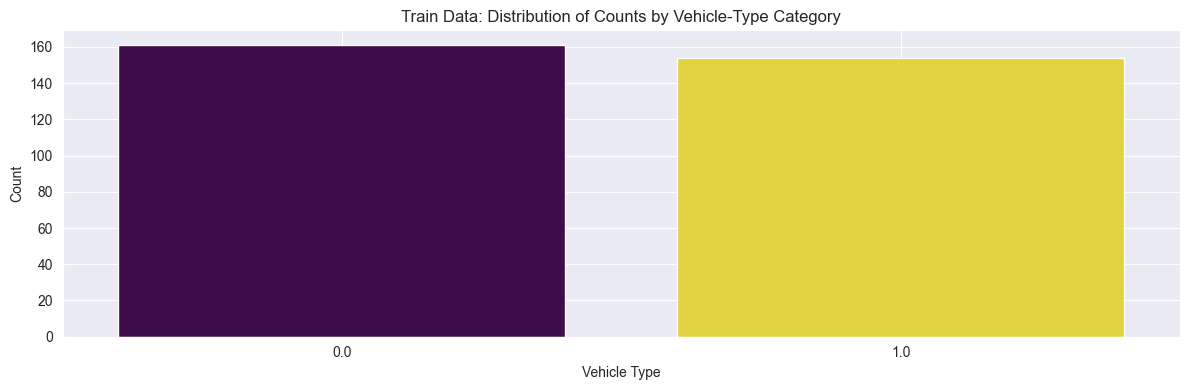

In [21]:
# Class counts
y_train_counts = y_train.value_counts().reset_index()

# Unique classes
categories = y_train_counts.vehicle_type.unique()

# Colors per class
colors = plt.cm.get_cmap('viridis', len(categories)).colors

sns.set_style("darkgrid")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.barplot(x="vehicle_type", y="count", data=y_train_counts, ax=axes, palette=colors)

plt.xlabel("Vehicle Type")
plt.ylabel("Count")
plt.title("Train Data: Distribution of Counts by Vehicle-Type Category")

# plt.legend(categories)
plt.tight_layout()
plt.grid(True)
plt.show()

- Test Data

In [22]:
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 79 entries, 243 to 267
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   load_capacity   79 non-null     float64
 1   vehicle_weight  79 non-null     float64
 2   engine_cc       79 non-null     float64
dtypes: float64(3)
memory usage: 2.5 KB


In [23]:
y_test.info()

<class 'pandas.core.series.Series'>
Index: 79 entries, 243 to 267
Series name: vehicle_type
Non-Null Count  Dtype  
--------------  -----  
79 non-null     float64
dtypes: float64(1)
memory usage: 1.2 KB


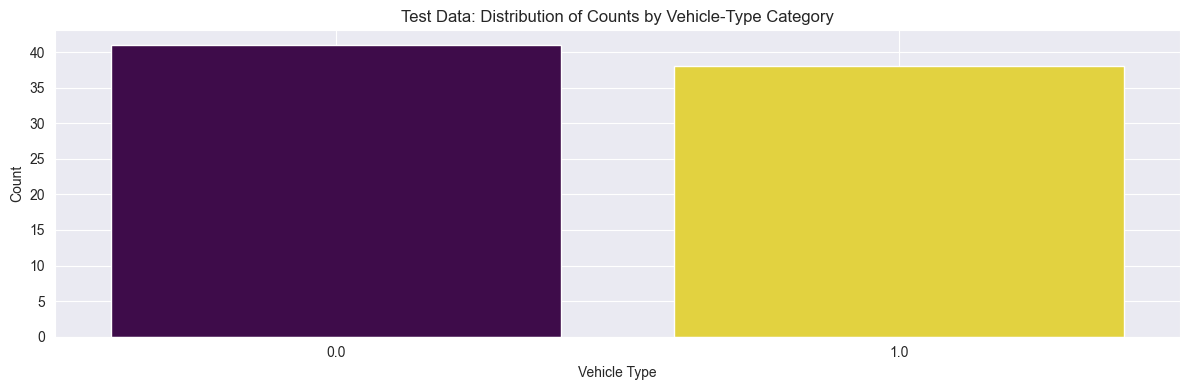

In [24]:
# Class counts
y_test_counts = y_test.value_counts().reset_index()

# Unique classes
categories = y_test_counts.vehicle_type.unique()

# Colors per class
colors = plt.cm.get_cmap('viridis', len(categories)).colors

sns.set_style("darkgrid")
fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(12, 4))
sns.barplot(x="vehicle_type", y="count", data=y_test_counts, ax=axes, palette=colors)

plt.xlabel("Vehicle Type")
plt.ylabel("Count")
plt.title("Test Data: Distribution of Counts by Vehicle-Type Category")

# plt.legend(categories)
plt.tight_layout()
plt.grid(True)
plt.show()

Observation

- Both classes exists in Train and Test data

<!--  -->

- Train & Test: Target Data Distributions

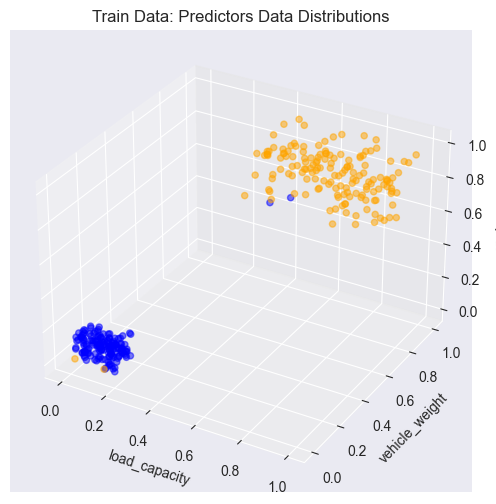

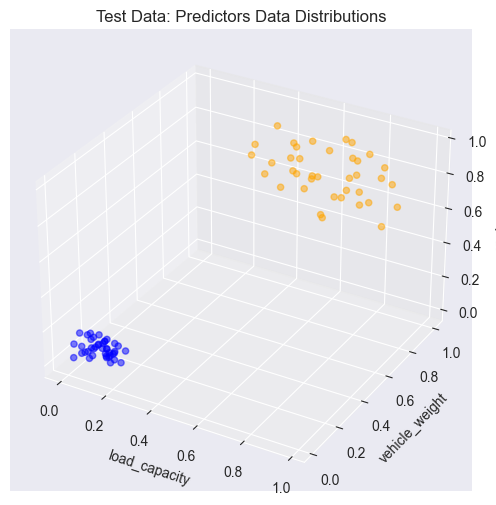

In [25]:
col_1 = "load_capacity"; col_2 = "vehicle_weight"; col_3 = "engine_cc"

sns.set_style("dark")
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111, projection='3d')
color_map = {0: 'blue', 1: 'orange'}
colors = [color_map[x] for x in y_train]
ax.scatter(X_train[col_1],
            X_train[col_2],
            X_train[col_3],
            #c='red',
            c=colors,
            marker='o', 
            alpha=0.5)
ax.set_xlabel(col_1)
ax.set_ylabel(col_2)
ax.set_zlabel(col_3)
# plt.title("{} vs {} vs {}".format(col_1, col_2, col_3))
plt.title("Train Data: Predictors Data Distributions")
plt.show()

sns.set_style("dark")
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111, projection='3d')
color_map = {0: 'blue', 1: 'orange'}
colors = [color_map[x] for x in y_test]
ax.scatter(X_test[col_1],
            X_test[col_2],
            X_test[col_3],
            #c='red',
            c=colors,
            marker='o', 
            alpha=0.5)
ax.set_xlabel(col_1)
ax.set_ylabel(col_2)
ax.set_zlabel(col_3)
# plt.title("{} vs {} vs {}".format(col_1, col_2, col_3))
plt.title("Test Data: Predictors Data Distributions")
plt.show()

<!--  -->

### Identify Influential Observations: Which Effect Model Training
 - i.e., Outliers or wrongly labeled classes, which were penalizing model training coefficients.

In [26]:
X_train.head(2)

,load_capacity,vehicle_weight,engine_cc
208,0.920067,0.731761,0.873829
154,0.108914,0.043930,0.044948


In [27]:
df_temp_train = X_train.copy(deep=True)
df_temp_train["vehicle_type"] = y_train

Optimization terminated successfully.
         Current function value: 0.063479
         Iterations 9


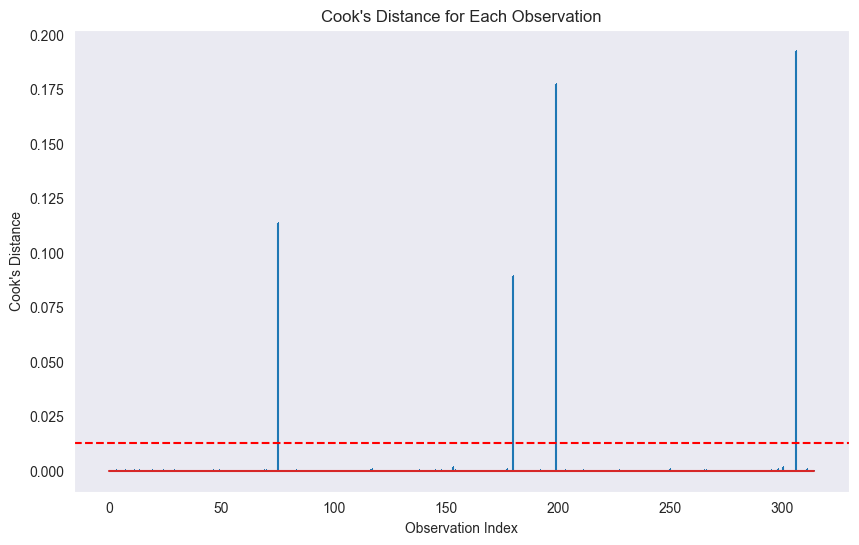

Influential points at indices: [ 75 180 199 306]


In [28]:
n_samples = len(X_train)

# Fit logistic regression model
model = smf.logit(formula='vehicle_type ~ load_capacity + vehicle_weight + engine_cc', data=df_temp_train).fit()

# Calculate Cook's distance
influence = model.get_influence()
cooks_d = influence.cooks_distance[0]

# Add Cook's distance to the dataframe
df_temp_train['cooks_d'] = cooks_d

# Plot Cook's distance
sns.set_style("dark")
plt.figure(figsize=(10, 6))
plt.stem(np.arange(n_samples), cooks_d, markerfmt=",")
plt.axhline(4 / n_samples, color='r', linestyle='--')
plt.xlabel('Observation Index')
plt.ylabel('Cook\'s Distance')
plt.title('Cook\'s Distance for Each Observation')
plt.show()

# Identify influential points
threshold = 4 / n_samples
influential_points = np.where(cooks_d > threshold)[0]
print(f"Influential points at indices: {influential_points}")

In [62]:
df_temp_train.head(5)

,load_capacity,vehicle_weight,engine_cc,vehicle_type,cooks_d
208,1.652061,0.777019,1.101629,1.0,0.000022
154,-0.875396,-1.033737,-1.046556,0.0,0.000011
53,-0.949199,-0.785485,-1.080089,0.0,0.000046
295,1.251973,0.551675,0.635724,1.0,0.000321
111,-0.830683,-0.912967,-0.814652,0.0,0.000031


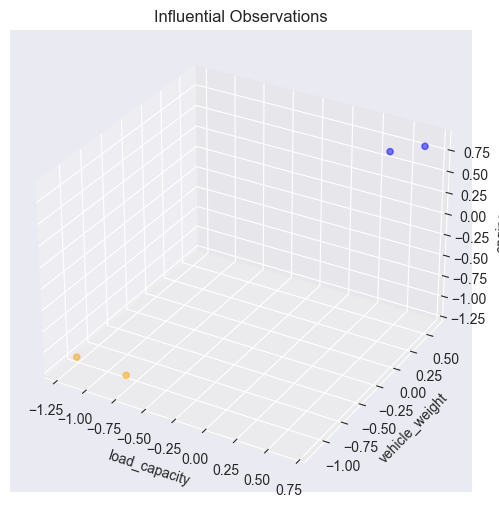

In [67]:
df_plot_outliers = df_temp_train.iloc[[75, 180, 199, 306],:]

sns.set_style("dark")
fig = plt.figure(figsize=(15,6))
ax = fig.add_subplot(111, projection='3d')
color_map = {0: 'blue', 1: 'orange'}
colors = [color_map[x] for x in df_plot_outliers.vehicle_type]
ax.scatter(df_plot_outliers[col_1],
            df_plot_outliers[col_2],
            df_plot_outliers[col_3],
            #c='red',
            c=colors,
            marker='o', 
            alpha=0.5)
ax.set_xlabel(col_1)
ax.set_ylabel(col_2)
ax.set_zlabel(col_3)
# plt.title("{} vs {} vs {}".format(col_1, col_2, col_3))
plt.title("Influential Observations")
plt.show()

Observation

- The cook distance here exactly found the influential points, which we wantedly induced into traing data as outliers.
- Like this we can find the influential points in the training data and avoid them from the training data for model training.
- `By looking cook distance, it penalize the points which are prediction outliers in training i.e., having cook distance [prediction error value] > threshold`.

<!--  -->

### Logistic Regression Training

In [29]:
# Initialize Logistic Regression Model
logistic_reg = LogisticRegression()

- **Hyper Parameters Tuning**
    - C: Inverse of regularization strength, i.e. the C = 1/lambda. Higher the value of C, the less the model is regularized, where lower the value of C, the more the model is regularized. Regularization is used to avoid overfitting, i.e., the model is penalized for having more number of features and having large useless coefficients.

In [30]:
param_grid = {
    'C': [10**-3, 10**-2, 10**-1, 10, 10**2, 10**3], # 0.001, 0.01, 0.1, 1, 1, 100, 1000 
    'penalty': ["l1", "l2", "elasticnet", "none"], # penality type
    "solver": ["lgfgs", "liblinear", "saga"] # solvers for optimization problem solving
}

In [31]:
# Grid Search 
grid_search = GridSearchCV(logistic_reg, param_grid=param_grid, cv=5, scoring="accuracy")
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5, estimator=LogisticRegression(),
             param_grid={'C': [0.001, 0.01, 0.1, 10, 100, 1000],
                         'penalty': ['l1', 'l2', 'elasticnet', 'none'],
                         'solver': ['lgfgs', 'liblinear', 'saga']},
             scoring='accuracy')

In [32]:
# Best Parameters
grid_search.best_params_

{'C': 0.01, 'penalty': 'l2', 'solver': 'liblinear'}

In [33]:
# Best Model
log_reg_class_best_model = grid_search.best_estimator_

<!--  -->

### Model Evaluation

In [34]:
y_preds = log_reg_class_best_model.predict(X_test)
y_preds[:5]

array([1., 0., 0., 1., 0.])

In [35]:
y_preds_prob = log_reg_class_best_model.predict_proba(X_test)
y_preds_prob[:5]

array([[0.35613596, 0.64386404],
       [0.52638116, 0.47361884],
       [0.53373995, 0.46626005],
       [0.36523712, 0.63476288],
       [0.53495882, 0.46504118]])

In [36]:
# Accuracy Score
accuracy_score(y_test, y_preds)

1.0

In [37]:
# Classification Report
print(classification_report(y_test, y_preds))

              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00        41
         1.0       1.00      1.00      1.00        38

    accuracy                           1.00        79
   macro avg       1.00      1.00      1.00        79
weighted avg       1.00      1.00      1.00        79



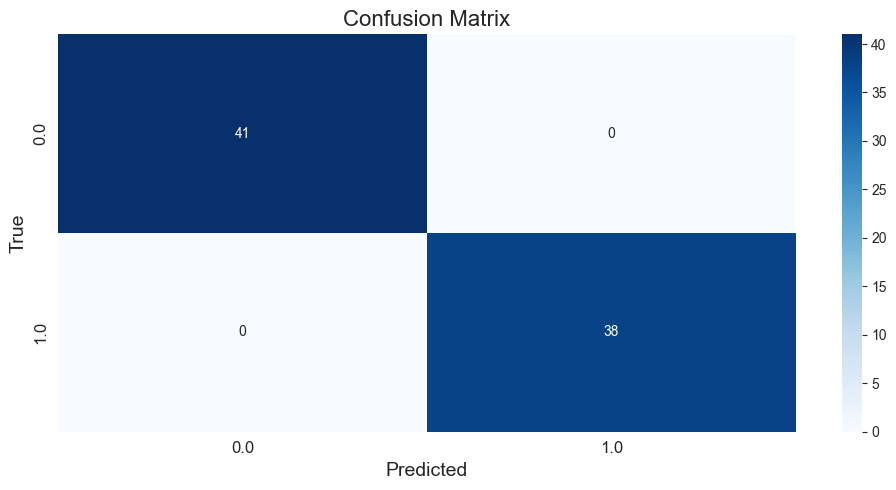

In [38]:
# Compute confusion matrix
cm = confusion_matrix(y_test, y_preds)
labels = np.unique(y_test)

# Plot confusion matrix
sns.set_style("dark")
fig, ax = plt.subplots(figsize=(10, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('True', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
# ax.set_xticklabels([])
# ax.set_yticklabels([])
# plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
plt.show()

[0. 0. 0. 1.] [0.         0.02631579 1.         1.        ] [       inf 0.67042354 0.6204185  0.45157294]
AUC score: 1.0


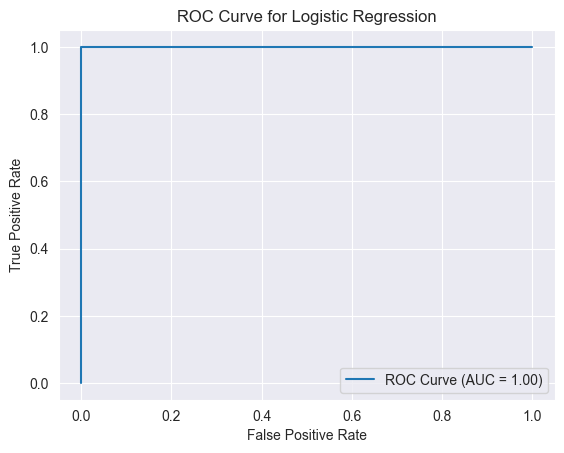

In [42]:
y_class1_proba = y_preds_prob[:, 1]  # Probability of positive class

# Calculate False Positive Rate (FPR) and True Positive Rate (TPR)
fpr, tpr, thresholds = roc_curve(y_test, y_class1_proba)
print(fpr, tpr, thresholds)

# Calculate AUC score
auc_score = auc(fpr, tpr)
print('AUC score:', auc_score)

# Basic plot (replace with your preferred plotting library)
sns.set_style("dark")
plt.plot(fpr, tpr, label='ROC Curve (AUC = {:.2f})'.format(auc_score))
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Logistic Regression')
plt.legend()
plt.grid(True)
plt.show()